In [ ]:
#Predict yield curve changes from fomc minutes data

* First, make sure to clean your data. You can use the data-cleaning techniques that you practiced in the Text preprocessing checkpoint. But keep in mind that every text dataset is likely to have its own particular cleaning requirements. Make sure to clean your dataset appropriately.
* If your dataset includes numerical features, then work on them for cleaning purposes; for example, deal with any missing values and outliers.
* After the data-cleaning step, do some exploratory data analysis to get to know your dataset better. In the exploratory data analysis, analyze your numerical features as well as your text features. If you feel that converting your text features into a numerical form is required for your exploratory analysis, then you can do this step after vectorizing your text.
* Convert your text features into numerical form. You're free to choose your method. You can use BoW, TF-IDF, word2vec, or any other method that you'd like to experiment with. It's a good idea to use several methods so that you can compare the results with respect to the methods that you apply.
* You can choose whatever NLP task you want. You're completely free in your choice. Here are some possible options:

    1. Sentiment analysis
    2. Text classification
    3. Topic modeling
    4. Developing a more sophisticated chatbot than what you've already developed in this module
    5. Training a deep-learning model for a supervised or unsupervised task of your choice


In [ ]:
#list of minutes link (1993 onward):
# https://www.fedsearch.org/fomc-docs/search?advanced_search=true&fomc_document_type=minutes&text=&search_precision=All+Words&from_month=3&from_year=1936&to_month=12&to_year=2020&sort=Most+Recent+First&Search=Search

My goal is to predict changes in the federal funds rate using minutes from the federal open market committee

In [270]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import time
import PyPDF2
import io
import re
import urllib.request
import pickle
import fitz
import os

from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split as tts
from nltk.corpus.reader.plaintext import CategorizedPlaintextCorpusReader
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

In [272]:
#functions for getting to the correct page to find the minutes
def minutesbutton(s):
    x = ('Minutes' in s.text and 
         'Executive' not in s.text 
         #'Historical Minutes' in s.text or 
         #'Minutes of Action' in s.text or 
         #'Minutes (Including' in s.text
        )
    return x
def findminuteslinks(soup):
    return [s['href'] for s in soup.find_all('a', class_='btn') if minutesbutton(s)]
def getsoup(link):
    r=requests.get(link)
    soup=BeautifulSoup(r.text)
    time.sleep(1)
    return soup
def correctlinks(linkfromhomepage):
    soup= getsoup(linkfromhomepage)
    minuteslinks=findminuteslinks(soup)
    if len(minuteslinks)>0:
        minuteslinks=['https://fraser.stlouisfed.org'+minuteslink for minuteslink in minuteslinks]
    return minuteslinks

def getpdflink(minuteslink):
    soup= getsoup(minuteslink)#'https://fraser.stlouisfed.org'+
    try:
        link_end= soup.find(text=re.compile('Download \(pdf\)')).parent['href']
        return 'https://fraser.stlouisfed.org'+link_end
    except:
        return None
def downloadpdf(pdflink):
    name=pdflink.split('/')[-1]
    r=requests.get(pdflink)
    time.sleep(1)
    file_destination_path='/Users/jamesmoss/Documents/GitHub/Notes and Exercises/IndividualExercises/Week15/FedMinutes/'
    with open(file_destination_path+'pdfs/'+name+'.pdf', 'wb') as f:
        f.write(r.content)
def getpdfs(originallink, minuteslinks):
    if len(minuteslinks)>0:
        for minuteslink in minuteslinks:
            pdflink=getpdflink(minuteslink)
            downloadpdf(pdflink)
    else:
        try:
            pdflink=getpdflink(originallink)
            downloadpdf(pdflink)
        except:
            pass
        
def listify(l):
    if isinstance(l, list):
        return l
    else:
        return [l]

def remove_names1993(doc):
    # Removes all text before "for immediate release", only works on docs after 1993
    deleteBefore= re.search("[Ff]or\s[Ii]mmediate\s[Rr]elease", \
                            doc).start() + len ('for immediate release')
    return doc[deleteBefore:]


## 0. Loading the data

In [4]:
FOMC_url='https://fraser.stlouisfed.org/title/federal-open-market-committee-meeting-minutes-transcripts-documents-677?browse=1930s'

r=requests.get(FOMC_url)

In [5]:
soup=BeautifulSoup(r.text)

In [6]:
meetings=soup.find_all('a', class_='list-item')#[0]['href']

In [7]:
meetings[0].span.text.strip().strip('Meeting, ')

'July 20, 1933'

## Making a dataframe with relevant links and dates

In [3]:
decades=['1930s','1940s','1950s','1960s','1970s','1980s','1990s','2000s','2010s']
links=[]
dates=[]

for decade in decades:
    #get the soup info
    fomc_url='https://fraser.stlouisfed.org/title/federal-open-market-committee-meeting-minutes-transcripts-documents-677?browse='+decade
    r=requests.get(fomc_url)
    soup=BeautifulSoup(r.text)
    meetings=soup.find_all('a', class_='list-item')
    for meeting in meetings:
        link='https://fraser.stlouisfed.org'+meeting['href']
        date=meeting.span.text.strip()
        
        #go to the link
        #get the link that says minutes or historical minutes
        # can get it from the text here:?
        #class="btn btn-success btn-sm btn-sm btn-block goto-btn"
        links.append(link)
        dates.append(date)
    time.sleep(1)

In [4]:
minutes=pd.DataFrame(list(zip(dates, links)), columns =['type_date', 'links'])
minutes.head(5)

,type_date,links
0,"Meeting, July 20, 1933",https://fraser.stlouisfed.org/title/federal-op...
1,"Meeting, September 21, 1933",https://fraser.stlouisfed.org/title/federal-op...
2,"Meeting, October 10, 1933",https://fraser.stlouisfed.org/title/federal-op...
3,"Meeting, October 25, 1933",https://fraser.stlouisfed.org/title/federal-op...
4,"Meeting, March 5, 1934",https://fraser.stlouisfed.org/title/federal-op...


In [5]:
#todo: improve this later
def clean_date(date):
    date=date.replace('(Unscheduled)','')
    date=date.split(', ')
    date=[date[0], date[-1]].join(', ')
    return date

minutes['context']=minutes.type_date.str.split(pat=', ', n=1, expand=False).str[0]
minutes['date']=minutes.type_date.str.split(pat=', ', n=1, expand=False).str[1]
minutes['unscheduled']=minutes.type_date.str.contains('(Unscheduled)', regex=False)
minutes['date']=minutes.date.str.replace('(Unscheduled)','')
#minutes['date']=pd.to_datetime(minutes['date'], errors='coerce')

#minutes['datestring']=minutes['date'].dt.strftime('%Y%m%d')#there might be stuff after the date, like (Unscheduled)
    
#minutesv are for historical minutes

#the datestring is added onto the end of this
#https://fraser.stlouisfed.org/files/docs/historical/FOMC/meetingdocuments/

In [6]:
#minutes.type_date.str.contains('Meeting')
minutes.head(2)

,type_date,links,context,date,unscheduled
0,"Meeting, July 20, 1933",https://fraser.stlouisfed.org/title/federal-op...,Meeting,"July 20, 1933",False
1,"Meeting, September 21, 1933",https://fraser.stlouisfed.org/title/federal-op...,Meeting,"September 21, 1933",False


In [26]:
#minutes[minutes.date.isna()].type_date
#minutes2.isna().sum()

In [23]:
minutes2=minutes.dropna()

In [27]:
minutes2['minuteslinks']=minutes2['links'].apply(lambda x: correctlinks(x))

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
#minutes_copy=minutes2.copy()

In [96]:
minutes2=minutes_copy.copy()

In [98]:
#minutes2.loc[minutes2.minuteslinks.str.len()==0, 'minuteslinks']=[minutes2['links']]
minutes2['minuteslinks'][minutes2['minuteslinks'].str.len()==0]=minutes2['links']

/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
minutes2['minuteslinks']=minutes2['minuteslinks'].apply(lambda x: listify(x))

In [114]:
minutes2['pdflinks']=minutes2['minuteslinks'].apply(lambda x: [getpdflink(link) for link in x])

## Saving the DataFrame

In [120]:
minutes2.to_csv('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minuteslinks_dates.csv')
#Unnamed column was the index

In [123]:
minutes2.to_pickle('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minuteslinks_datesDF.pkl')

In [7]:
#minutes2=pd.read_csv('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minuteslinks_dates.csv')

In [12]:
minutes2=pickle.load(open('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minuteslinks_datesDF.pkl', 'rb'))

## Saving the PDFs

In [32]:
file_destination_path='/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minutespdfs/'

for date in minutes2.pdflinks:
    for url in date:
        try:
            name=url.split('/')[-1]
            r=requests.get(url)
            time.sleep(1)

            with open(file_destination_path+name, 'wb') as f:
                f.write(r.content)
        except:
            continue

## Making the text files

In [52]:
# for document in file:
text_path='/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minutestexts/'
pdf_path='/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minutespdfs/'
pdf_list=os.listdir(pdf_path)
for document in pdf_list:
    textfile_name=document.split('.')[0]
    try:
        with fitz.open(pdf_path+document) as doc:
            text = ""
            for page in doc:
                text += page.getText()
            with open(text_path+textfile_name+'.txt', 'w') as textfile:
                textfile.write(text)
    except:
        print(document)

mupdf: cannot recognize version marker
mupdf: no objects found


.DS_Store


## Creating the corpus

In [14]:
text_path='/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/minutestexts/'
text_list=os.listdir(text_path)

In [13]:
def find_date(filename):
    datestring=re.findall('20\d\d\d\d\d\d|19\d\d\d\d\d\d|21\d\d\d\d\d\d', filename)
    return datestring
def text_from_filename(directory, filename):
    with open(directory+filename, 'r') as file:
        text = file.read()
    return text

In [ ]:
sample_list=text_list[:20]
for file in sample_list:
    if find_date(file):
        print(file)
        print(find_date(file)[0])

In [21]:
minutes={}
minutes['date']=[]
minutes['filename']=[]
#minutes['text']=[]
count=0
for txtfile in text_list:
    if find_date(txtfile) and '.txt' in txtfile:
        count=count+1
        minutes['date'].append(find_date(txtfile)[0])
        minutes['filename'].append(txtfile)
print(count)

964


I messed up my first time through and used the following code to correct my mistake, but it should be fixed above.

In [90]:
#Debugging
#TODO: use the above to apply to filename column to recalculate dates, or just redo it
# def fix_date(doc_name):
#     try:
#         date=find_date(doc_name)[0]
#         return date
#     except:
#         print(doc_name)
#         return np.nan
# minutes_df['date']=minutes_df['filename'].apply(lambda x: fix_date(x))

900917ConfCall.txt
marconf.txt


In [22]:
minutes_df=pd.DataFrame.from_dict(minutes)
minutes_df.head(2)

,date,filename
0,20121023,fomchistmin19560417.txt
1,20121023,fomcminutes20090603.txt
2,20121023,fomcmoa19680206.txt
3,20121023,19971216min.txt
4,20121023,19851001MoA.txt


In [23]:
minutes_df['raw_text']=minutes_df['filename'].apply(lambda x: text_from_filename(text_path, x))

In [93]:
minutes_df.head(2)

,date,filename,raw_text,preprocessed,datetime,next_month
0,19560417,fomchistmin19560417.txt,A meeting of the Federal Open Market Committee...,meet feder open market committe held offic boa...,2012-10-23,2012-11-01
1,20090603,fomcminutes20090603.txt,Minutes of the Federal Open Market Committee \...,minut feder open market committe june 2009 joi...,2012-10-23,2012-11-01


## Preprocessing the text

In [36]:
def preprocess(doc):
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer('english')
    
    tokenized = word_tokenize(doc)

    cleaned = [stemmer.stem(lemmatizer.lemmatize(token.lower())) 
               for token in tokenized 
               if not token.lower() in stopwords.words('english') 
               if token.isalnum()] #should I make this also include numbers?
               

    untokenized = " ".join(cleaned)
    #preprocessed.append(untokenized)
        
    return untokenized

In [38]:
minutes_df['preprocessed']=minutes_df['raw_text'].apply(lambda x: preprocess(x))

In [94]:
minutes_df['datetime']=pd.to_datetime(minutes_df['date'])

In [95]:
minutes_df['next_month']=minutes_df['datetime']+pd.offsets.MonthBegin(0)

In [99]:
minutes_df=minutes_df.dropna()
minutes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 962 entries, 0 to 963
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          962 non-null    object        
 1   filename      962 non-null    object        
 2   raw_text      962 non-null    object        
 3   preprocessed  962 non-null    object        
 4   datetime      962 non-null    datetime64[ns]
 5   next_month    962 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 52.6+ KB


In [100]:
minutes_df.to_pickle('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/preprocessed_minutes_df.pkl')

## Getting the federal funds rate changes

In [43]:
fed_funds=pd.read_csv('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/FEDFUNDS.csv')

In [46]:
fed_funds['datetime']=pd.to_datetime(fed_funds['DATE'])

In [48]:
fed_funds['shifted']=fed_funds['FEDFUNDS'].shift(1)

In [50]:
fed_funds['change']=fed_funds['FEDFUNDS']-fed_funds['shifted']

In [266]:
fed_funds['change_cat']=0
fed_funds.loc[fed_funds['change']>.125, 'change_cat']=1
fed_funds.loc[fed_funds['change']<-.125, 'change_cat']=-1

In [118]:
fed_funds['change_binary']=0
fed_funds.loc[fed_funds['change'].abs()>.125, 'change_binary']=1

In [119]:
fed_funds.head(3)

,DATE,FEDFUNDS,datetime,shifted,change,change_cat,change_binary
0,1954-07-01,0.80,1954-07-01,NaN,NaN,0,0
1,1954-08-01,1.22,1954-08-01,0.80,0.42,1,1
2,1954-09-01,1.07,1954-09-01,1.22,-0.15,-1,1


I added the change column, which indicates month over month change in the interest rate; change_cat, which indicates if there was negative (-1), no (0), or positive (1) change in the federal funds rate.

In [110]:
fed_funds.datetime.min()

Timestamp('1954-07-01 00:00:00')

Remember that the minutes_df dataset contains minutes from before 1954, which will be lost after merging

## Merging the data

In [121]:
merged_df=minutes_df.merge(fed_funds, how='inner', left_on='next_month', right_on='datetime', suffixes=['_min','_fed'])
merged_df=merged_df.drop(columns=['shifted'])

In [286]:
merged_df.tail()

,date,filename,raw_text,preprocessed,datetime_min,next_month,DATE,FEDFUNDS,datetime_fed,change,change_cat,change_binary,change_1,change_binary_1
820,19880630,19880630MoA.txt,Meeting of the Federal Open Market Committee\n...,meet feder open market committe june 1988 minu...,1988-06-30,1988-07-01,1988-07-01,7.75,1988-07-01,0.24,1,1,0.26,1.0
821,19720718,fomcmoa19720718.txt,Meeting of Federal Open Market Committee\nJuly...,meet feder open market committe juli 18 1972 m...,1972-07-18,1972-08-01,1972-08-01,4.81,1972-08-01,0.26,1,1,-0.17,1.0
822,19830429,FOMC19830429confcall.txt,Federal Open Market Committee\nConference Call...,feder open market committe confer call april 2...,1983-04-29,1983-05-01,1983-05-01,8.63,1983-05-01,-0.17,-1,1,-1.05,1.0
823,19841107,19841107MoA.txt,Meeting of the Federal Open Market Committee\n...,meet feder open market committe novemb 7 1984 ...,1984-11-07,1984-12-01,1984-12-01,8.38,1984-12-01,-1.05,-1,1,-0.01,0.0
824,20101103,fomcminutes20101103.txt,Minutes of the Federal Open Market Committee \...,minut feder open market committe novemb 2010 m...,2010-11-03,2010-12-01,2010-12-01,0.18,2010-12-01,-0.01,-1,0,NaN,NaN


In [255]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 825 entries, 0 to 824
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           825 non-null    object        
 1   filename       825 non-null    object        
 2   raw_text       825 non-null    object        
 3   preprocessed   825 non-null    object        
 4   datetime_min   825 non-null    datetime64[ns]
 5   next_month     825 non-null    datetime64[ns]
 6   DATE           825 non-null    object        
 7   FEDFUNDS       825 non-null    float64       
 8   datetime_fed   825 non-null    datetime64[ns]
 9   change         824 non-null    float64       
 10  change_cat     825 non-null    int64         
 11  change_binary  825 non-null    int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(5)
memory usage: 83.8+ KB


shiting the changes down one

In [285]:
merged_df['change_1']=merged_df['change'].shift(-1)
merged_df['change_binary_1']=merged_df['change_binary'].shift(-1)

## EDA

Examining federal funds rate changes:

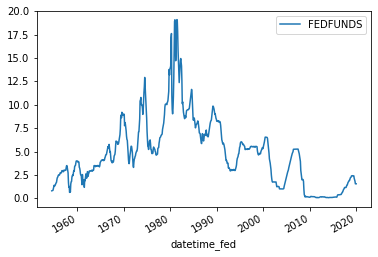

In [268]:
merged_df.plot(y='FEDFUNDS',x='datetime_fed')

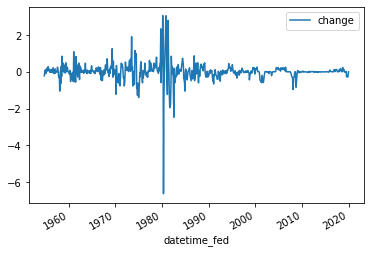

In [267]:
merged_df.plot(y='change',x='datetime_fed')

## Making the classifiers

### binary classification:

#### Using all available dates (back to 1954):

In [147]:
rfc_model

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

In [136]:
#why is this model so good?
model

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

In [248]:
#random forest
x_train, x_test, y_train, y_test = tts(merged_df['preprocessed'], merged_df['change_binary'], test_size=0.3)

rfc_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=75, min_samples_leaf=4, max_depth=12)),
])

rfc_model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=12, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                  

In [249]:
rfc_model.score(x_train, y_train)

0.9376083188908145

In [250]:
rfc_model_predictions = rfc_model.predict(x_test)
print(classification_report(y_test, rfc_model_predictions))

              precision    recall  f1-score   support

           0       0.74      0.62      0.67       136
           1       0.61      0.74      0.67       112

    accuracy                           0.67       248
   macro avg       0.68      0.68      0.67       248
weighted avg       0.69      0.67      0.67       248



In [135]:
#why is this one so good?
rfc_model_predictions = model.predict(x_test)
print(classification_report(y_test, rfc_model_predictions))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       126
           1       0.88      0.93      0.90       122

    accuracy                           0.90       248
   macro avg       0.90      0.90      0.90       248
weighted avg       0.91      0.90      0.90       248



In [148]:
model.to_pickle('/Users/jamesmoss/Documents/GitHub/CapstoneProjects/Capstone4/good_binary_class_model.pkl')

AttributeError: 'Pipeline' object has no attribute 'to_pickle'

In [253]:
#logistic regression
log_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('scl', StandardScaler(with_mean=False)),
    ('log', LogisticRegression()),
])

log_model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                                  sublinear_tf=False, use_idf=True)),
                ('scl',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('log',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_s

In [254]:
log_model_predictions = log_model.predict(x_test)
print(classification_report(y_test, log_model_predictions))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69       136
           1       0.63      0.71      0.67       112

    accuracy                           0.68       248
   macro avg       0.68      0.68      0.68       248
weighted avg       0.69      0.68      0.68       248



In [229]:
# AdaBoost
ada_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('log', AdaBoostClassifier()),
])
ada_model.fit(x_train, y_train)
ada_model.score(x_train, y_train)

0.9410745233968805

In [230]:
ada_model_predictions = ada_model.predict(x_test)
print(classification_report(y_test, ada_model_predictions))

              precision    recall  f1-score   support

           0       0.68      0.73      0.71       127
           1       0.70      0.64      0.67       121

    accuracy                           0.69       248
   macro avg       0.69      0.69      0.69       248
weighted avg       0.69      0.69      0.69       248



#### Post 1993:

In [287]:
merged_1993_df=merged_df[merged_df['datetime_min'] > '1993-01-01']
merged_1993_df.sort_values(by=['datetime_min']).head(3)

,date,filename,raw_text,preprocessed,datetime_min,next_month,DATE,FEDFUNDS,datetime_fed,change,change_cat,change_binary,change_1,change_binary_1
81,19930203,19930203min.txt,"Meeting of February 2-3, 1993\nA meeting of th...",meet februari 1993 meet feder open market comm...,1993-02-03,1993-03-01,1993-03-01,3.07,1993-03-01,0.04,-1,0,0.04,0.0
80,19930218,FOMC19930218confcall.txt,FEDERAL OPEN MARKET COMMITTEE\nCONFERENCE CALL...,feder open market committe confer call februar...,1993-02-18,1993-03-01,1993-03-01,3.07,1993-03-01,0.04,-1,0,0.04,0.0
82,19930301,FOMC19930301confcall.txt,FEDERAL OPEN MARKET COMMITTEE\nCONFERENCE CALL...,feder open market committe confer call march 1...,1993-03-01,1993-03-01,1993-03-01,3.07,1993-03-01,0.04,-1,0,0.21,1.0


In [288]:
merged_1993_df.change_binary_1.value_counts()

1.0    130
0.0    129
Name: change_binary_1, dtype: int64

In [263]:
merged_1993_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 1 to 824
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           260 non-null    object        
 1   filename       260 non-null    object        
 2   raw_text       260 non-null    object        
 3   preprocessed   260 non-null    object        
 4   datetime_min   260 non-null    datetime64[ns]
 5   next_month     260 non-null    datetime64[ns]
 6   DATE           260 non-null    object        
 7   FEDFUNDS       260 non-null    float64       
 8   datetime_fed   260 non-null    datetime64[ns]
 9   change         260 non-null    float64       
 10  change_cat     260 non-null    int64         
 11  change_binary  260 non-null    int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(5)
memory usage: 36.4+ KB


In [262]:
x_train1993, x_test1993, y_train1993, y_test1993 = tts(merged_1993_df['preprocessed'], merged_1993_df['change_binary'], test_size=0.3)

rfc_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=75, min_samples_leaf=4, max_depth=12)),
])

rfc_model.fit(x_train1993, y_train1993)
rfc_model_predictions = model.predict(x_test1993)
print(classification_report(y_test1993, rfc_model_predictions))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96        59
           1       0.94      0.79      0.86        19

    accuracy                           0.94        78
   macro avg       0.94      0.89      0.91        78
weighted avg       0.94      0.94      0.93        78



Now looking one period into the future:

In [ ]:
x_train1993, x_test1993, y_train1993, y_test1993 = tts(merged_1993_df['preprocessed'], merged_1993_df['change_binary_1'], test_size=0.3)

rfc_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=75, min_samples_leaf=4, max_depth=12)),
])

rfc_model.fit(x_train1993, y_train1993)
rfc_model_predictions = model.predict(x_test1993)
print(classification_report(y_test1993, rfc_model_predictions))

Trying regression, rather than classification:

In [282]:
x_train1993, x_test1993, y_train1993, y_test1993 = tts(merged_1993_df['preprocessed'], merged_1993_df['change'], test_size=0.3)

rfc_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestRegressor(n_estimators=200, min_samples_leaf=10, max_depth=12)),
])

rfc_model.fit(x_train1993, y_train1993)
#rfc_model_predictions = model.predict(x_test1993)
print(rfc_model.score(x_train1993, y_train1993))
print(rfc_model.score(x_test1993, y_test1993))


0.603802449384434
0.47472169127071673


In [265]:
merged_1993_df['change_cat'].value_counts()

-1    225
 1     35
Name: change_cat, dtype: int64

In [264]:
#Now trying to predict multiple classes:

x_train1993, x_test1993, y_train1993, y_test1993 = tts(merged_1993_df['preprocessed'], merged_1993_df['change_cat'], test_size=0.3)

rfc_model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=75, min_samples_leaf=4, max_depth=12)),
])

rfc_model.fit(x_train1993, y_train1993)
rfc_model_predictions = model.predict(x_test1993)
print(classification_report(y_test1993, rfc_model_predictions))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        68
           0       0.00      0.00      0.00         0
           1       0.60      0.90      0.72        10

    accuracy                           0.12        78
   macro avg       0.20      0.30      0.24        78
weighted avg       0.08      0.12      0.09        78



/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jamesmoss/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1993 is when the modern minutes of the FOMC developed, and they began to become more transparent about planning with the public. You can see that the predictive power of the model greatly improves

## Extra Code:

In [ ]:
#creating the corpus
meeting_types=['MoA', 'fomcminutes', 'fomcmoa', 'minutesv', 'fomchistmin']
pdf_url_base='https://fraser.stlouisfed.org/files/docs/historical/FOMC/meetingdocuments/'
file_destination_path='/Users/jamesmoss/Documents/GitHub/Notes and Exercises/IndividualExercises/Week15/FedMinutes/'

for date_string in minutes2['datestring']:
    try:
        r2=requests.get(pdf_url_base+date_string+meeting_type[0]+'.pdf')
        #request(pdf_url_base+date_string+meeting_type[0]+'.pdf', file_destination_path+date_string+'.pdf')
    except:
        try:
            r2=requests.get(pdf_url_base+date_string+meeting_type[1]+'.pdf')
            time.sleep(1)
        except:
            try:
                r2=requests.get(pdf_url_base+date_string+meeting_type[2]+'.pdf')
                time.sleep(1)
            except:
                try:
                    r2=requests.get(pdf_url_base+date_string+meeting_type[3]+'.pdf')
                    time.sleep(1)
                except:
                    print(date_string)
    with open(file_destination_path+'pdfs/'+date_string+'.pdf', 'wb') as f:
        f.write(r2.content)

    with io.BytesIO(r2.content) as open_pdf_file:
        pdf_reader = PyPDF2.PdfFileReader(open_pdf_file)
        num_pages = pdf_reader.numPages

        if pdf_reader.isEncrypted:
            pdf_reader.decrypt("")
            #print(pdf_reader.getPage(page).extractText())
            with open(file_destination_path+date_string+".txt", "w") as text_file:
                for page in range(num_pages):
                    text_file.write(pdf_reader.getPage(page).extractText())
        else:
            #print(pdf_reader.getPage(page).extractText())
            with open(file_destination_path+date_string+".txt", "w") as text_file:
                for page in range(num_pages):
                    text_file.write(pdf_reader.getPage(page).extractText())
#hopefully multiple meetings didn't occur on the same date


In [ ]:
#finished doing 1930s by hand

In [133]:
soup.div.find(attrs={'id':'content'}).find('div', class_='tab-content').find(attrs={'role':'tabpanel'}).div
soup.find(class_="hidden-xs hidden-sm col-md-5 browse-by-right")
#.find(attrs={'style':'display'})


<div class="hidden-xs hidden-sm col-md-5 browse-by-right">
<div class="instructions-text">
<div class="instructions-text-arrow pull-left"></div>
<div style="padding-top: 10%">Select a resource to view.</div>
</div>
</div>

In [44]:
#r2=requests.get('https://fraser.stlouisfed.org/files/docs/historical/FOMC/meetingdocuments/19800812MoA.pdf')
with io.BytesIO(r2.content) as open_pdf_file:
    pdf_reader = PyPDF2.PdfFileReader(open_pdf_file)
    num_pages = pdf_reader.numPages

    if pdf_reader.isEncrypted:
        pdf_reader.decrypt("")
        #print(pdf_reader.getPage(page).extractText())
        with open("/Users/jamesmoss/Documents/GitHub/Notes and Exercises/IndividualExercises/Week15/FedMinutes/test.txt", "w") as text_file:
            for page in range(num_pages):
                #print(pdf_reader.getPage(page).extractText(), file=text_file)
                text_file.write(pdf_reader.getPage(page).extractText())
    else:
        #print(pdf_reader.getPage(page).extractText())
        with open("/Users/jamesmoss/Documents/GitHub/Notes and Exercises/IndividualExercises/Week15/FedMinutes/test.txt", "w") as text_file:
            for page in range(num_pages):
            #print(pdf_reader.getPage(page).extractText(), file=text_file)
                text_file.write(pdf_reader.getPage(page).extractText())

            
            

In [ ]:
with open(date_string".txt", "w") as text_file:
    print(pdf_reader.getPage(page).extractText(), file=text_file)


In [ ]:
#Download Historical Minutes (PDF)
#Download Minutes of Actions (PDF)

# 	 Download Minutes of Actions (PDF)
    #soup6.find_all(text=re.compile('Historical Minutes'))[0].parent.parent
#soup6.find(text=re.compile('Historical Minutes'))[0].parent.parent['href']
#soup6.find_all('a', class_='btn')[0].text
#text=re.compile('Historical Minutes'))
#'Historical Minutes' in s.text or 'Minutes of Action' in s.text


Notes on hand minutes files:

Early minutes template: https://fraser.stlouisfed.org/files/docs/historical/FOMC/meetingdocuments/19500228Minutesv.pdf

19560110: 
https://fraser.stlouisfed.org/files/docs/historical/FOMC/meetingdocuments/fomchistmin19560110.pdf

(1950s done)